<a href="https://colab.research.google.com/github/AvivGelfand/Fine-tuning-Large-Language-Models/blob/main/Llama_2_Classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Connecting google drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


## Installing and Importing Libraries

In [ ]:
%pip install -q accelerate peft bitsandbytes transformers trl pytorch-lightning datasets pyTelegramBotAPI #sacremoses # %pip install setfit

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 297.4/297.4 kB 7.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.1/199.1 kB 24.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 102.2/102.2 MB 16.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 225.0/225.0 kB 29.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 801.6/801.6 kB 17.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 510.5/510.5 kB 48.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 240.6/240.6 kB 30.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 102.0/102.0 kB 13.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 841.5/841.5 kB 60.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 15.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 25.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 19.5 MB/s eta 0:00:00


In [ ]:
# Import necessary libraries
import pandas as pd
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
import numpy as np
import torch
from datasets import load_dataset, Dataset
from transformers import Trainer,TrainingArguments, EarlyStoppingCallback,TrainerCallback,TrainerState,TrainerControl
from transformers import BitsAndBytesConfig, AutoModelForSequenceClassification
from transformers import LlamaForSequenceClassification
from transformers import DataCollatorWithPadding
from peft import LoraConfig, get_peft_model, prepare_model_for_kbit_training, PeftModel, AutoPeftModelForCausalLM,TaskType,AutoPeftModelForSequenceClassification
import bitsandbytes as bnb
from google.colab import userdata
import telebot
import time
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
import plotly.figure_factory as ff
# import precision recall curve
from sklearn.metrics import precision_recall_curve,roc_auc_score
import io

## Loading Data Sets

In [ ]:
# Load your dataset with pandas
dataset_name = "/content/drive/MyDrive/BR_TRAIN_NEW.csv"
df = pd.read_csv(dataset_name)#.drop('length',axis=1)#.drop('instruction', axis=1)
# df=df.sample(frac=0.5).reset_index(drop=True)
# df.rename(columns={'GOOD_RECORD': 'label','input':'text'}, inplace=True)#.drop(columns='length')
# df['text'] = df['instruction'] + ' ' + df['text']
# df.drop('instruction', axis=1, inplace=True)#.drop(columns='length',axis=1, inplace=True)
print(df.shape)
df = df.drop_duplicates(subset='text', keep='first')
df.reset_index(drop=True,inplace=True)
print(df.shape)

br1 = df[df['label'] == 1].sample(frac=1,replace=False,random_state = 42).reset_index(drop=True)
br2 = df[df['label'] == 1].sample(frac=1,replace=False,random_state = 42).reset_index(drop=True)
nbr = df[df['label'] == 0].sample(frac=.8,random_state = 42).reset_index(drop=True)

(17474, 6)
(17474, 6)


In [ ]:
# prompt: import TfidfVectorizer KMeans train_test_split

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
# prompt: vectorize the text columns in nbr with tfidf, cluster it with k-means, save clusters as columns, split and stratify by the k-means cluster
# Initialize the TfidfVectorizer
vectorizer = TfidfVectorizer()
# Fit the vectorizer on the text column
X = vectorizer.fit_transform(nbr['text'])
# Perform K-means clustering
kmeans = KMeans(n_clusters=80)
kmeans.fit(X)
# Add cluster labels as a new column to the dataframe
nbr['cluster'] = kmeans.labels_

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [ ]:

# Split the dataset into train and test sets, stratifying by the cluster labels
nbr_big, nbr_small= train_test_split(nbr, test_size=0.5, stratify=nbr['cluster'], random_state=0)
display(nbr_big.head(1))
display(nbr_big.cluster.value_counts().to_frame().T)
display(nbr_small.head(1))
display(nbr_small.cluster.value_counts().to_frame().T)


,negotiationId,text,label,length,prob_old,BAD_RECORD_prob,cluster
107,5ff3a220b97211000176095f,"Judge,I hope you are doing well,I am asking fo...",0.0,347,0.501465,0.498444,15


cluster,0,7,10,12,50,61,59,47,39,19,...,40,16,34,66,77,46,65,68,20,60
count,398,385,294,254,244,233,200,190,144,132,...,25,25,21,20,20,18,13,13,12,12


,negotiationId,text,label,length,prob_old,BAD_RECORD_prob,cluster
478,6155ba8012e0d40001a23d5a,I live on the corner of comstock and Gallagher...,0.0,593,0.50177,0.499046,7


cluster,0,7,10,12,50,61,59,47,39,19,...,40,16,34,66,77,46,68,20,65,60
count,399,386,295,255,244,234,201,190,144,132,...,24,24,21,20,19,18,13,12,12,11


In [ ]:
df = df.reset_index(drop=True)
df=df.sample(frac=1,random_state = 42).reset_index(drop=True)
print(df.shape)
df['label']=df['label'].astype('float' )
# Step 2: Preprocess your dataset
print(df.label.value_counts())
print(df.label.value_counts(normalize=True))
df.info()
train_df= df
# # Step 3: Convert the pandas DataFrame to a Hugging Face dataset
train_dataset = Dataset.from_pandas(df[['negotiationId','text','label']])
print(train_dataset)

(17474, 6)
label
0.0    17239
1.0      193
Name: count, dtype: int64
label
0.0    0.988928
1.0    0.011072
Name: proportion, dtype: float64
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17474 entries, 0 to 17473
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   negotiationId    17474 non-null  object 
 1   text             17474 non-null  object 
 2   label            17432 non-null  float64
 3   length           17474 non-null  int64  
 4   prob_old         17472 non-null  float64
 5   BAD_RECORD_prob  17474 non-null  float64
dtypes: float64(3), int64(1), object(2)
memory usage: 819.2+ KB
Dataset({
    features: ['negotiationId', 'text', 'label'],
    num_rows: 17474
})


In [ ]:
# validation
eval_df = pd.read_csv("/content/drive/MyDrive/BR_EVAL_NEW.csv")#.drop('instruction', axis=1)
print()
eval_df = eval_df.drop_duplicates(subset='text', keep='first')
eval_df.reset_index(drop=True,inplace=True)
eval_df=eval_df.sample(frac=1,random_state = 42).reset_index(drop=True)
eval_df['label']=eval_df['label'].astype('float' )
eval_df = eval_df.reset_index(drop=True)
print(eval_df.shape)
# Step 3: Convert the pandas DataFrame to a Hugging Face dataset
eval_dataset = Dataset.from_pandas(eval_df[['negotiationId','text','label']])
# Now, your dataset is ready to be used with Hugging Face's transformers or for further processing
print(eval_dataset)




(5766, 5)
Dataset({
    features: ['negotiationId', 'text', 'label'],
    num_rows: 5766
})


In [ ]:
# test_large data
test_large_df = pd.read_csv("/content/drive/MyDrive/BR_TEST_NEW.csv")
test_large_df = test_large_df.drop_duplicates(subset='text', keep='first')
test_large_df.reset_index(drop=True,inplace=True)
test_large_df['label']=test_large_df['label'].astype('float')
# Step 3: Convert the pandas DataFrame to a Hugging Face dataset
test_large_dataset = Dataset.from_pandas(test_large_df[['negotiationId','text','label']])
# Now, your dataset is ready to be used with Hugging Face's transformers or for further processing
print(test_large_dataset)


Dataset({
    features: ['negotiationId', 'text', 'label'],
    num_rows: 5684
})


## LlamaTokenizerFast

In [ ]:
from transformers import LlamaTokenizerFast
tokenizer = LlamaTokenizerFast.from_pretrained("meta-llama/Llama-2-7b-hf",task_type="SEQ_CLS",)

# tokenizer = LlamaTokenizerFast.from_pretrained("meta-llama/Llama-2-7b-hf",t
tokenizer.pad_token = tokenizer.eos_token # Ensure the tokenizer is aware of the padding token

# print(tokenizer.encode("Hello this is a test"))
def tokenize_function(examples):
    return tokenizer(examples["text"], padding="max_length", truncation=True,max_length=1024)
# Apply the tokenizer to the datasets
tokenized_train_dataset = train_dataset.map(tokenize_function, batched=True,num_proc=4)
tokenized_eval_dataset = eval_dataset.map(tokenize_function, batched=True,num_proc=4)
tokenized_test_large_dataset = test_large_dataset.map(tokenize_function, batched=True,num_proc=4)
tokenized_train_dataset = tokenized_train_dataset.map(lambda examples: {'labels': examples['label']}, batched=True,num_proc=4)
tokenized_eval_dataset = tokenized_eval_dataset.map(lambda examples: {'labels': examples['label']}, batched=True,num_proc=4)
tokenized_test_large_dataset = tokenized_test_large_dataset.map(lambda examples: {'labels': examples['label']}, batched=True,num_proc=4)

tokenizer_config.json:   0%|          | 0.00/776 [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/500k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.84M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/414 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/multiprocess/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Map (num_proc=4):   0%|          | 0/17474 [00:00<?, ? examples/s]

Map (num_proc=4):   0%|          | 0/5766 [00:00<?, ? examples/s]

Map (num_proc=4):   0%|          | 0/5684 [00:00<?, ? examples/s]

Map (num_proc=4):   0%|          | 0/17474 [00:00<?, ? examples/s]

Map (num_proc=4):   0%|          | 0/5766 [00:00<?, ? examples/s]

Map (num_proc=4):   0%|          | 0/5684 [00:00<?, ? examples/s]

## LlamaForSequenceClassification

### config model and trianer

In [ ]:
chat_id = userdata.get('CHAT_ID')
bot_id = userdata.get('BOTTOKEN')

bot = telebot.TeleBot(bot_id)

model_nameHP="Llama-2-7b-hf"
output_dir = "./results"

import os

# Function to find the last checkpoint in the output directory
def find_last_checkpoint(output_dir):
    checkpoints = list(os.path.join(output_dir, d) for d in os.listdir(output_dir) if d.startswith("checkpoint-"))
    if checkpoints:
        return max(checkpoints, key=os.path.getmtime)  # Return the most recently modified directory
    else:
        return None
# BitsAndBytesConfig
q_config = BitsAndBytesConfig(load_in_4bit=True,bnb_4bit_quant_type="nf4",nb_4bit_use_double_quant=True,bnb_4bit_compute_dtype=torch.bfloat16)
n_gpus = torch.cuda.device_count()
max_memory = f'{40960}MB'
# model = AutoModelForSequenceClassification.from_pretrained("meta-llama/Llama-2-7b-hf",quantization_config=q_config,device_map="auto", max_memory = {i: max_memory for i in range(n_gpus)},torch_dtype = torch.bfloat16,num_labels=1,)
model = LlamaForSequenceClassification.from_pretrained("meta-llama/Llama-2-7b-hf",max_position_embeddings=1024,
                                                       num_labels=1,torch_dtype = torch.bfloat16,quantization_config=q_config,device_map="auto",
                      max_memory = {i: max_memory for i in range(n_gpus)},)

model.config.pad_token_id = tokenizer.pad_token_id
# model.resize_token_embeddings(len(tokenizer))  # added after chatgpt's advice # TODO: Try running it without this line
model.config.use_cache = False
# peft
peft_config = LoraConfig(r=16,lora_alpha=64,lora_dropout=0.5,bias="none",task_type=TaskType.SEQ_CLS,target_modules=['v_proj', 'down_proj', 'up_proj', 'q_proj', 'gate_proj', 'k_proj', 'o_proj'])
# model.gradient_checkpointing_enable()
model = prepare_model_for_kbit_training(model)
model = get_peft_model(model, peft_config)

# """"LOADING MODEL IF THIS IS WHAT YOU WANT"""
# model_path = '/content/drive/MyDrive/Models/BR_Fixed_Llama-2-7b-hf_1712766594.911408.pt'
# model.load_state_dict(torch.load(model_path))

# training_args and Trainer
training_args = TrainingArguments(output_dir=output_dir,bf16=True,
                                  learning_rate=1e-5,num_train_epochs=5,
                                  per_device_train_batch_size=16,per_device_eval_batch_size=64,
                                  logging_dir='./logs',  # TensorBoard logs will be saved here
                                  warmup_steps=100,
                                  logging_steps= 100 ,  # Log metrics every n steps
                                  save_steps=100,  # Save model every n steps
                                  evaluation_strategy="steps",  # Evaluate every logging_steps if eval dataset is provided
                                  eval_steps=100,  # Evaluation and logging steps
                                  load_best_model_at_end=True, weight_decay=0.05,
                                  # gradient_accumulation_steps=4,gradient_checkpointing=True,
                                  overwrite_output_dir=True, # THIS IS NEW
                                  )
# Dynamically pad the batches and remove unnecessary columns
data_collator = DataCollatorWithPadding(tokenizer=tokenizer, pad_to_multiple_of=8)

trainer = Trainer(model=model,args=training_args,train_dataset=tokenized_train_dataset,eval_dataset=tokenized_eval_dataset,tokenizer=tokenizer,data_collator=data_collator,
                  callbacks=[EarlyStoppingCallback(early_stopping_patience=3)],)
# compute_metrics=compute_metrics,#


### trainer.train()

In [ ]:

# SaveScoreCallback
class SaveScoreCallback(TrainerCallback):
    def __init__(self, model) -> None:
        super().__init__()
        self.model = model
    def on_save(self,args: TrainingArguments,state: TrainerState,control: TrainerControl,
                **kwargs ):
        fname = f"{args.output_dir}/checkpoint-{state.global_step}/score.original_module.pt"
        torch.save(model.model.score.original_module.state_dict(), fname)
# add
trainer.add_callback(SaveScoreCallback(model))
# train / fit
# Use this function to find the last checkpoint
last_checkpoint = find_last_checkpoint(output_dir)

# Resume training from the last checkpoint if it exists
if last_checkpoint:
    print(f"Resuming training from {last_checkpoint}")
    trainer.train(resume_from_checkpoint=last_checkpoint)
else:
    print("Starting training from scratch")
    trainer.train()

trainer.save_model("final-checkpoint")

# message_text = f"Master Bruce, training is finneshed"
# bot.send_message(chat_id,message_text);
model_nameHP="Llama-2-7b-hf"
run_id = time.time()
# save the model
model_path = f'/content/drive/MyDrive/Models/BR_Fixed_{model_nameHP}_{run_id}.pt'
torch.save(model.state_dict(), model_path)
message_text = f"model state_dict saved"
bot.send_message(chat_id,message_text);

# Inference

In [ ]:
def predict_probabilities(trainer, dataset):
  pred_dict = trainer.predict(dataset)
  logits = pred_dict[0] # Use your actual logits here
  probabilities = 1 / (1 + np.exp(-logits)) # Convert logits to probabilities using the sigmoid function
  probabilities = probabilities.flatten() # Flatten arrays for compatibility with sklearn.metrics function
  label_ids = np.array(pred_dict[1])
  label_ids = label_ids.flatten()
  return label_ids, probabilities

def plot_curves(label_ids, probabilities, col, set_name):
    precision, recall, thresholds = precision_recall_curve(label_ids, probabilities)
    thresholds = np.append(thresholds, 1)  # Append 1 to thresholds for completeness

    # Ensure probabilities is a numpy array
    probabilities_np = np.array(probabilities)  # Convert if `probabilities` is not already a numpy array

    # Then, you can safely use operations like the following
    # Vectorized prediction calculation
    predictions = probabilities_np[:, None] >= thresholds[None, :]
    # predictions = probabilities[:, None] >= thresholds[None, :]


    # Ensure label_ids is a boolean array and compatible for broadcasting
    label_ids_bool = np.array(label_ids, dtype=bool)[:, None]
    # Corrected bitwise operations
    # Vectorized computation for true positives, false positives, false negatives, and true negatives
    # These are conceptual; actual implementation might differ based on the desired metrics
    tp = (predictions & label_ids_bool).sum(axis=0)
    fp = (predictions & ~label_ids_bool).sum(axis=0)
    fn = (~predictions & label_ids_bool).sum(axis=0)
    tn = (~predictions & ~label_ids_bool).sum(axis=0)


    # Calculate metrics based on the confusion matrix components
    f1_scores = 2 * tp / (2 * tp + fp + fn)
    accuracy_scores = (tp + tn) / (tp + fp + fn + tn)

    # Plotting (remains unchanged)
    fig = go.Figure()
    fig.add_trace(go.Scatter(x=thresholds, y=precision[:-1], mode='lines', name='Precision'))
    fig.add_trace(go.Scatter(x=thresholds, y=recall[:-1], mode='lines', name='Recall'))
    fig.add_trace(go.Scatter(x=thresholds, y=f1_scores, mode='lines', name='F1'))
    fig.add_trace(go.Scatter(x=thresholds, y=accuracy_scores, mode='lines', name='Accuracy'))
    fig.update_layout(title=f'{col} {set_name} Set - Metric vs. Threshold Curves', xaxis_title='Threshold', yaxis_title='Metric Value', yaxis=dict(range=[0, 1]), width=800, height=600, hovermode='x unified')
    fig.show()

import numpy as np
def cm_plot(final_threshold,probabilities,label_ids,col,set_name):

  # Apply threshold to convert probabilities to binary predictions
  predictions = (probabilities > final_threshold).astype(int)
  cm_temp = confusion_matrix(label_ids, predictions)
  met_dic_test = {'Accuracy': accuracy_score(label_ids, predictions),'Roc_Auc': roc_auc_score(label_ids, predictions),
                  'F1_score': f1_score(label_ids, predictions),'Precision': precision_score(label_ids, predictions,),
                  'Recall': recall_score(label_ids, predictions),'Support': cm_temp[1][0] + cm_temp[1][1],
                  'TP' : cm_temp[1][1],'FP' : cm_temp[0][1],'TN' : cm_temp[0][0],'FN' : cm_temp[1][0]}
  metrics_df = pd.DataFrame([met_dic_test])
  display(metrics_df)
  fig, ax = plt.subplots(figsize=(7, 7))
  sns.heatmap(cm_temp, annot=True,  annot_kws={"size": 18} ,fmt="d", cmap="Wistia", ax=ax,cbar=False)
  ax.set_xlabel("Predicted Values", fontsize=19)
  ax.set_ylabel("Actual Values", fontsize=19)
  ax.set_title(f"{col} - {set_name}"# - Confusion Matrix"
               , fontsize=20)
  message_text = f"{col} - {set_name} - final_threshold: {final_threshold}" +f" {col} {set_name} metrics: {str(met_dic_test)}"
  bot.send_message(chat_id,message_text);
  # Save the plot to an in-memory file
  buf = io.BytesIO()
  plt.savefig(buf, format='png')
  buf.seek(0)  # Go to the start of the IO stream
  bot.send_photo(chat_id, buf)  # Replace 'chat_id' with the actual chat ID
  plt.show();


import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score, f1_score, precision_score, recall_score
import io  # Make sure to import necessary modules like io if not already done

def func(final_threshold, probabilities, label_ids, col, set_name):
    # Apply threshold to convert probabilities to binary predictions
    predictions = (probabilities > final_threshold).astype(int)
    cm_temp = confusion_matrix(label_ids, predictions)
    met_dic_test = {
        'Accuracy': accuracy_score(label_ids, predictions),
        'Roc_Auc': roc_auc_score(label_ids, predictions),
        'F1_score': f1_score(label_ids, predictions),
        'Precision': precision_score(label_ids, predictions),
        'Recall': recall_score(label_ids, predictions),
        'Support': cm_temp[1][0] + cm_temp[1][1],
        'TP': cm_temp[1][1],
        'FP': cm_temp[0][1],
        'TN': cm_temp[0][0],
        'FN': cm_temp[1][0]
    }
    metrics_df = pd.DataFrame([met_dic_test])
    display(metrics_df)

    # Increase figure size for better visibility
    fig, ax = plt.subplots(figsize=(7, 7))  # Adjust figure size as needed

    # Customize heatmap
    sns.heatmap(cm_temp, annot=True, annot_kws={"size": 24, "weight": "bold"}, fmt="d", cmap="Wistia", ax=ax, cbar=False)  # Increase annot size for bigger text

    # Enhance font size and make them bold
    # Set tick labels for x and y axes
    ax.set_xlabel("Predicted Values", fontsize=24,)# fontweight='bold')
    ax.set_ylabel("Actual Values", fontsize=24,)# fontweight='bold')
    ax.set_title(f"{col} - {set_name}"# - Confusion Matrix"
                 , fontsize=25, fontweight='bold')

    ax.set_xticklabels(ax.get_xticklabels(), fontsize=20,
                      #  fontweight='bold',
                       rotation=45)  # Rotate x-axis labels
    ax.set_yticklabels(ax.get_yticklabels(), fontsize=20,
                      #  fontweight='bold',
                       rotation=45)  # Rotate y-axis labels as well

    # Formatting message text to send
    message_text = f"{col} - {set_name} - final_threshold: {final_threshold}" + f" {col} {set_name} metrics: {str(met_dic_test)}"
    bot.send_message(chat_id, message_text)

    # Save the plot to an in-memory file
    buf = io.BytesIO()
    plt.savefig(buf, format='png', bbox_inches='tight')  # Ensure the entire plot is saved
    buf.seek(0)  # Go to the start of the IO stream
    bot.send_photo(chat_id, buf)  # Replace 'chat_id' with the actual chat ID



def plot_confusion_matrices_v2(csv_file):
    # Load the data
    data = pd.read_csv(csv_file)

    # Determine the number of rows (and thus the number of plots)
    num_plots = data.shape[0]

    # Calculate the number of rows and columns for the subplot grid
    num_rows = int(np.ceil(np.sqrt(num_plots)))
    num_cols = int(np.ceil(num_plots / num_rows))

    # Create the subplot grid
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(num_cols*5, num_rows*5))
    axes = axes.flatten()  # Flatten to simplify indexing

    # Plot the confusion matrices for each data row
    for i, row in data.iterrows():
        matrix = np.array([[ row['TN'],  row['FP']], [row['FN'],row['TP'],]])
        sns.heatmap(matrix, annot=True, fmt="d", cmap="Wistia", annot_kws={"size": 20}, ax=axes[i], cbar=False)
        axes[i].set_title(row['Label'],fontsize=20,fontweight='bold')
        axes[i].set_xlabel('Predicted',fontsize=18)
        axes[i].set_ylabel('Actual',fontsize=18)
        axes[i].set_xticklabels(axes[i].get_xticklabels(),fontsize=18, rotation=45)
        axes[i].set_yticklabels(axes[i].get_yticklabels(),fontsize=18, rotation=45)
        axes[i]

    # For any remaining axes, make them invisible
    for j in range(i + 1, len(axes)):
        axes[j].set_visible(False)
    # plt.subplots_adjust(hspace=0.55,wspace=0.5)  # Increase the vertical space between rows
    # Adjust layout

    plt.tight_layout()
    plt.show()

# Let's plot again with the adjusted function
# plot_confusion_matrices_v2('/content/Book1.csv')



In [ ]:
col="BAD_RECORD"
print("Train probs Done")
train_label_ids, train_df[f'{col}_prob'] = predict_probabilities(trainer=trainer, dataset=tokenized_train_dataset)
print("Val probs Done")
val_label_ids, eval_df[f'{col}_prob'] = predict_probabilities(trainer=trainer, dataset=tokenized_eval_dataset)
print("Test probs Done")
test_label_ids, test_large_df[f'{col}_prob'] = predict_probabilities(trainer=trainer, dataset=tokenized_test_large_dataset)

In [ ]:
plot_curves(test_label_ids,test_large_df[f'{col}_prob'],col,'test')

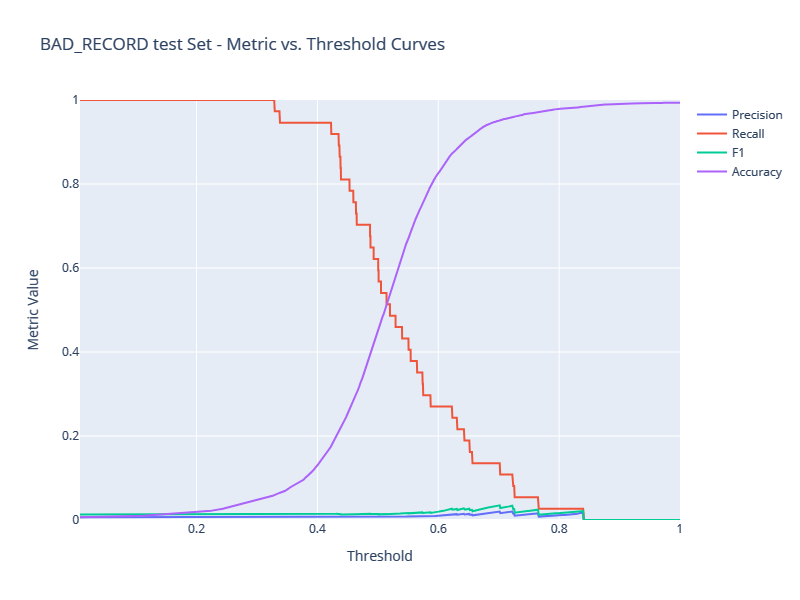

,Accuracy,Roc_Auc,F1_score,Precision,Recall,Support,TP,FP,TN,FN
0,0.451267,0.535886,0.014534,0.007353,0.621622,37,23,3105,2542,14


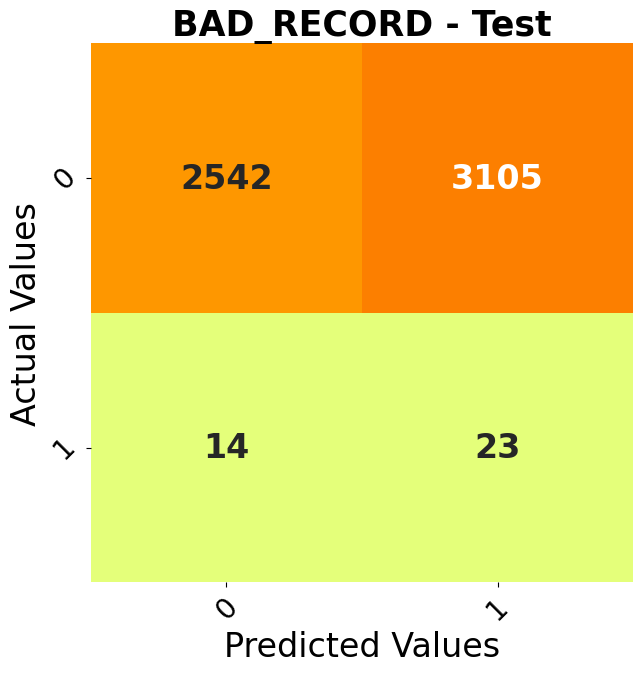

In [ ]:
final_threshold = 0.5
func(final_threshold=final_threshold,probabilities=test_large_df[f'{col}_prob'],label_ids=test_large_df['label'],col=col,set_name="Test")

,Accuracy,Roc_Auc,F1_score,Precision,Recall,Support,TP,FP,TN,FN
0,0.472555,0.51975,0.013816,0.006993,0.567568,37,21,2982,2665,16


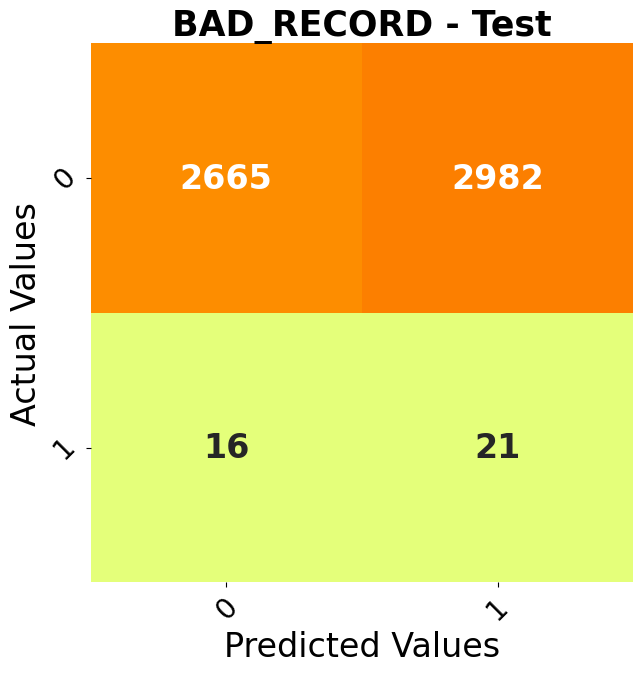

In [ ]:
final_threshold = 0.505
func(final_threshold=final_threshold,probabilities=test_large_df[f'{col}_prob'],label_ids=test_large_df['label'],col=col,set_name="Test")

In [ ]:
train_df.to_csv('/content/drive/MyDrive/BR_TRAIN_NEW.csv',index=False)
eval_df.to_csv('/content/drive/MyDrive/BR_EVAL_NEW.csv',index=False)
test_large_df.to_csv('/content/drive/MyDrive/BR_TEST_NEW.csv',index=False)

## Inference Train Set

In [ ]:
# predict
pred_dict = trainer.predict(tokenized_train_dataset) # GPU MEMORY USED HERE

# Example logits from your predictions
logits =  pred_dict[0] # Use your actual logits here
# Convert logits to probabilities using the sigmoid function
probabilities = 1 / (1 + np.exp(-logits))
# Flatten arrays for compatibility with sklearn.metrics function
probabilities = probabilities.flatten()
label_ids = np.array(pred_dict[1])
label_ids = label_ids.flatten()

# Compute precision and recall for various thresholds
precision, recall, thresholds = precision_recall_curve(label_ids, probabilities)
thresholds = np.append(thresholds, 1)  # Append 1 to thresholds for completeness

# Calculate F1 and accuracy for each threshold
f1_scores = []
accuracy_scores = []
for threshold in thresholds:
    predictions = (probabilities >= threshold).astype(int)
    f1_scores.append(f1_score(label_ids, predictions))
    accuracy_scores.append(accuracy_score(label_ids, predictions))

# Plotting
fig = go.Figure()
# metric-Threshold curve
fig.add_trace(go.Scatter(x=thresholds, y=precision[:-1], mode='lines', name='Precision'))
fig.add_trace(go.Scatter(x=thresholds, y=recall[:-1], mode='lines', name='Recall'))
fig.add_trace(go.Scatter(x=thresholds, y=f1_scores, mode='lines', name='F1 Score'))
fig.add_trace(go.Scatter(x=thresholds, y=accuracy_scores, mode='lines', name='Accuracy'))
fig.update_layout(title='CIRCUMSTANCES Train Set - Metric vs. Threshold Curves',xaxis_title='Threshold',yaxis_title='Metric Value',yaxis=dict(range=[0, 1]),width=800, height=600)
fig.show()


bot = telebot.TeleBot(bot_id)
message_text = f"Master Bruce, CIRCUMSTANCES train prediction is finneshed"
bot.send_message(chat_id,message_text);

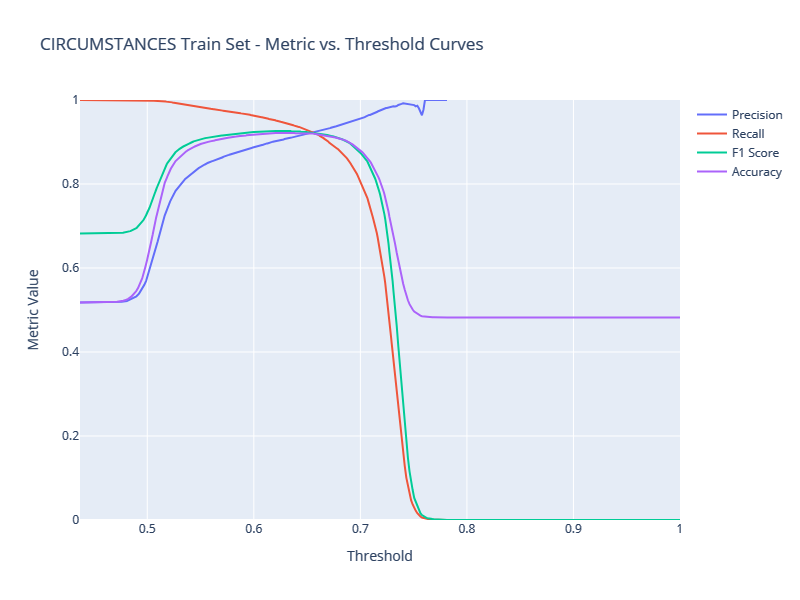

,Accuracy,Roc_Auc,F1_score,Precision,Recall,Support,TP,FP,TN,FN
0,0.921543,0.972085,0.921491,0.921772,0.921543,9006,8440,799,7593,566


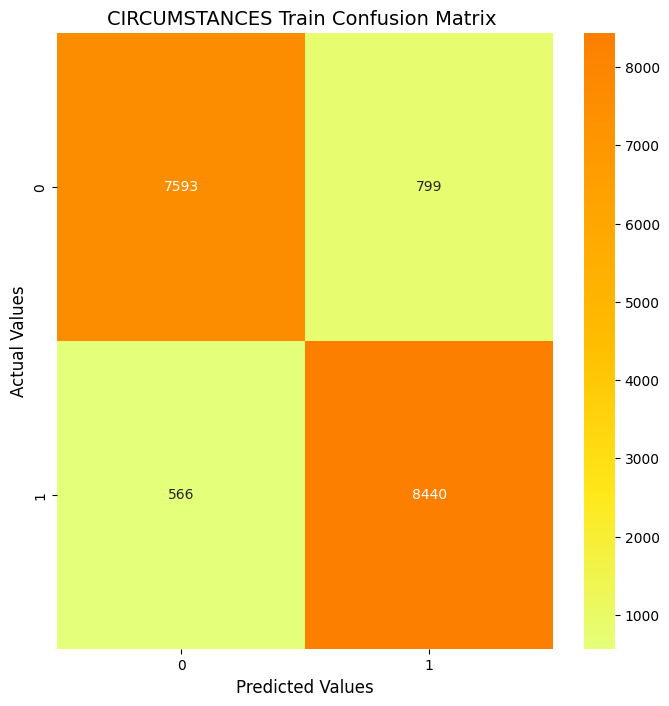

In [ ]:
# Apply wanted to convert probabilities to binary predictions
final_threshold = 0.64# Set your desired threshold here
predictions = (probabilities > final_threshold).astype(int)

cm = confusion_matrix(label_ids, predictions)
met_dic = {'Accuracy': accuracy_score(label_ids, predictions),'Roc_Auc': roc_auc_score(label_ids, probabilities),'F1_score': f1_score(label_ids, predictions,average='weighted'),
        'Precision': precision_score(label_ids, predictions,average='weighted'),'Recall': recall_score(label_ids, predictions,average='weighted'),'Support': cm[1][0]+cm[1][1],
        'TP' : cm[1][1],'FP' : cm[0][1],'TN' : cm[0][0],'FN' : cm[1][0]}
metrics_df= pd.DataFrame([met_dic])
display(metrics_df)

message_text = f"CIRCUMSTANCES Train metrics: {str(met_dic)}"
bot.send_message(chat_id,message_text);
# Set up the plot
fig, ax = plt.subplots(figsize=(8, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Wistia", ax=ax)

# Set labels and title
ax.set_xlabel("Predicted Values", fontsize=12)
ax.set_ylabel("Actual Values", fontsize=12)
ax.set_title("CIRCUMSTANCES Train Confusion Matrix ", fontsize=14)
message_text = f"CIRCUMSTANCES Train final_threshold: {final_threshold}"
bot.send_message(chat_id,message_text);
# # Save the plot to an in-memory file
buf = io.BytesIO()
plt.savefig(buf, format='png')
buf.seek(0)  # Go to the start of the IO stream
# Send the plot
bot.send_photo(chat_id, buf)  # Replace 'chat_id' with the actual chat ID
plt.show()



In [ ]:
train_df['prob'] = probabilities
# train_df['pred'] = predictions
train_df.to_csv('/content/drive/MyDrive/CIRC_train.csv',index=False)
# train_df.sort_values(by='prob', ascending=False).head(15)


## Validation Inference

In [ ]:
pred_dict_val = trainer.predict(tokenized_eval_dataset) # GPU MEMORY USED HERE

# Example logits from your predictions
logits_val =  pred_dict_val[0] # Use your actual logits here
# Convert logits to probabilities using the sigmoid function
probabilities_val = 1 / (1 + np.exp(-logits_val))
# Flatten arrays for compatibility with sklearn.metrics function
probabilities_val = probabilities_val.flatten()
label_ids_val = np.array(pred_dict_val[1])
label_ids_val = label_ids_val.flatten()

eval_df['prob'] = probabilities_val
# eval_df['pred'] = predictions_val
# eval_df['label'] = label_ids_val
eval_df.to_csv('/content/drive/MyDrive/CIRC_validation.csv', index=False)

# Compute precision and recall for various thresholds
precision, recall, thresholds = precision_recall_curve(label_ids_val, probabilities_val)
thresholds = np.append(thresholds, 1)  # Append 1 to thresholds for completeness

# Calculate F1 and accuracy for each threshold
f1_scores = []
accuracy_scores = []
for threshold in thresholds:
    predictions = (probabilities_val >= threshold).astype(int)
    f1_scores.append(f1_score(label_ids_val, predictions))
    accuracy_scores.append(accuracy_score(label_ids_val, predictions))

# Plotting
fig = go.Figure()
# metric-Threshold curve
fig.add_trace(go.Scatter(x=thresholds, y=precision[:-1], mode='lines', name='Precision'))
fig.add_trace(go.Scatter(x=thresholds, y=recall[:-1], mode='lines', name='Recall'))
fig.add_trace(go.Scatter(x=thresholds, y=f1_scores, mode='lines', name='F1 Score'))
fig.add_trace(go.Scatter(x=thresholds, y=accuracy_scores, mode='lines', name='Accuracy'))
fig.update_layout(title='CIRCUMSTANCES Validation Set - Metric vs. Threshold Curves',xaxis_title='Threshold',yaxis_title='Metric Value',yaxis=dict(range=[0, 1]),width=800, height=600)
fig.show()


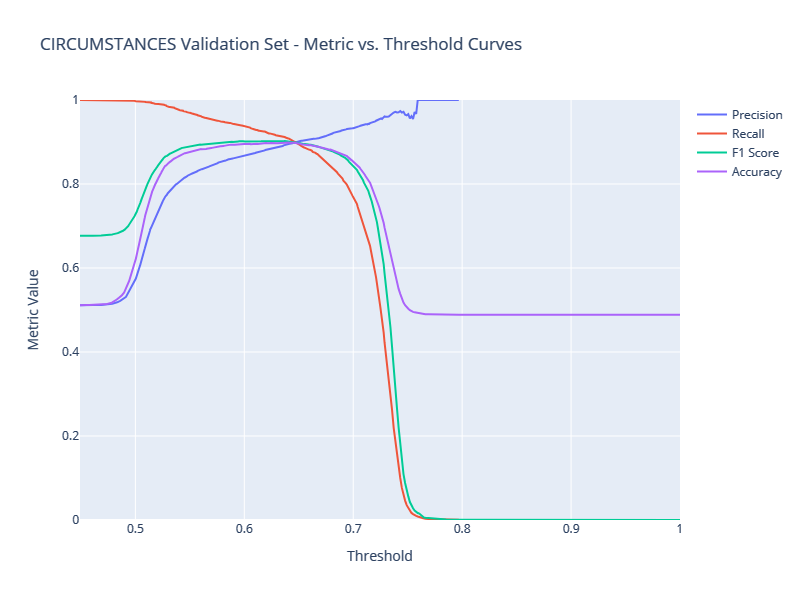

,Accuracy,Roc_Auc,F1_score,Precision,Recall,Support,TP,FP,TN,FN
0,0.892716,0.952521,0.893632,0.906163,0.881442,2969,2617,271,2567,352


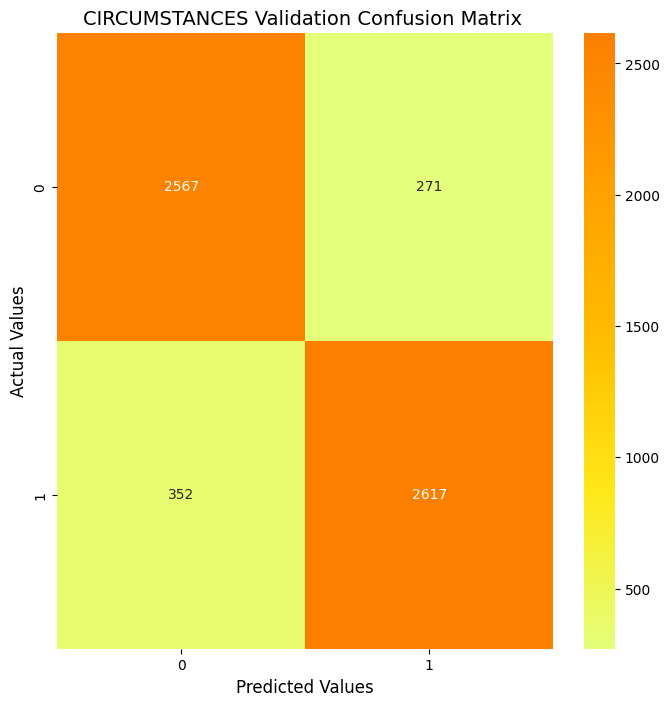

In [ ]:
# Apply wanted to convert probabilities to binary predictions
final_threshold = 0.66
predictions_val = (probabilities_val > final_threshold).astype(int) # threshold is set in the train section

cm_val = confusion_matrix(label_ids_val, predictions_val)
met_dic_val = {'Accuracy': accuracy_score(label_ids_val, predictions_val),'Roc_Auc': roc_auc_score(label_ids_val, probabilities_val),'F1_score': f1_score(label_ids_val, predictions_val),
        'Precision': precision_score(label_ids_val, predictions_val),'Recall': recall_score(label_ids_val, predictions_val),'Support': cm_val[1][0]+cm_val[1][1],
        'TP' : cm_val[1][1],'FP' : cm_val[0][1],'TN' : cm_val[0][0],'FN' : cm_val[1][0]}
metrics_df= pd.DataFrame([met_dic_val])
display(metrics_df)

message_text = f"CIRCUMSTANCES Val Metrics: {str(met_dic_val)}" + f"Final_threshold: {final_threshold}"
bot.send_message(chat_id,message_text);
# Set up the plot
fig, ax = plt.subplots(figsize=(8, 8))
# Choose a colormap for the confusion matrix
sns.heatmap(cm_val, annot=True, fmt="d", cmap="Wistia", ax=ax)
# Set labels and title
ax.set_xlabel("Predicted Values", fontsize=12)
ax.set_ylabel("Actual Values", fontsize=12)
ax.set_title("CIRCUMSTANCES Validation Confusion Matrix ", fontsize=14)
import io
# Save the plot to an in-memory file
buf = io.BytesIO()
plt.savefig(buf, format='png')
buf.seek(0)  # Go to the start of the IO stream
bot.send_photo(chat_id, buf)  # Replace 'chat_id' with the actual chat ID
plt.show()

# Test large

In [ ]:
# pred_dict_test_large = trainer.predict(tokenized_test_large_dataset)
# Example logits from your predictions
test_large_logits =  pred_dict_test_large[0] # Use your actual logits here
# Convert logits to probabilities using the sigmoid function
probabilities_test_large = 1 / (1 + np.exp(-test_large_logits))
# Flatten arrays for compatibility with precision_score function
probabilities_test_large = probabilities_test_large.flatten()
label_ids_test_large = np.array(pred_dict_test_large[1])  # Use your actual label_ids here
label_ids_test_large = label_ids_test_large.flatten()

# Compute precision and recall for various thresholds
precision, recall, thresholds = precision_recall_curve(label_ids_test_large, probabilities_test_large)
thresholds = np.append(thresholds, 1)  # Append 1 to thresholds for completeness

tps_ls = []
fps_ls = []
fns_ls = []
tns_ls = []
# Calculate F1 and accuracy for each threshold
f1_scores = []
accuracy_scores = []
for threshold in thresholds:
    predictions = (probabilities_test_large >= threshold).astype(int)
    f1_scores.append(f1_score(label_ids_test_large, predictions))
    accuracy_scores.append(accuracy_score(label_ids_test_large, predictions))
    cm_test_large = confusion_matrix(label_ids_test_large, predictions)
    tps_ls.append(cm_test_large[1][1])
    fps_ls.append(cm_test_large[0][1])
    fns_ls.append(cm_test_large[1][0])
    tns_ls.append(cm_test_large[0][0])

# Plotting
fig = go.Figure()
# metric-Threshold curve
fig.add_trace(go.Scatter(x=thresholds, y=precision[:-1], mode='lines', name='Precision'))
fig.add_trace(go.Scatter(x=thresholds, y=recall[:-1], mode='lines', name='Recall'))
fig.add_trace(go.Scatter(x=thresholds, y=f1_scores, mode='lines', name='F1 Score'))
fig.add_trace(go.Scatter(x=thresholds, y=accuracy_scores, mode='lines', name='Accuracy'))
fig.update_layout(title='CIRCUMSTANCES Test Set - Metric vs. Threshold Curves',xaxis_title='Threshold',yaxis_title='Metric Value',yaxis=dict(range=[0, 1]),width=800, height=600)
fig.show()


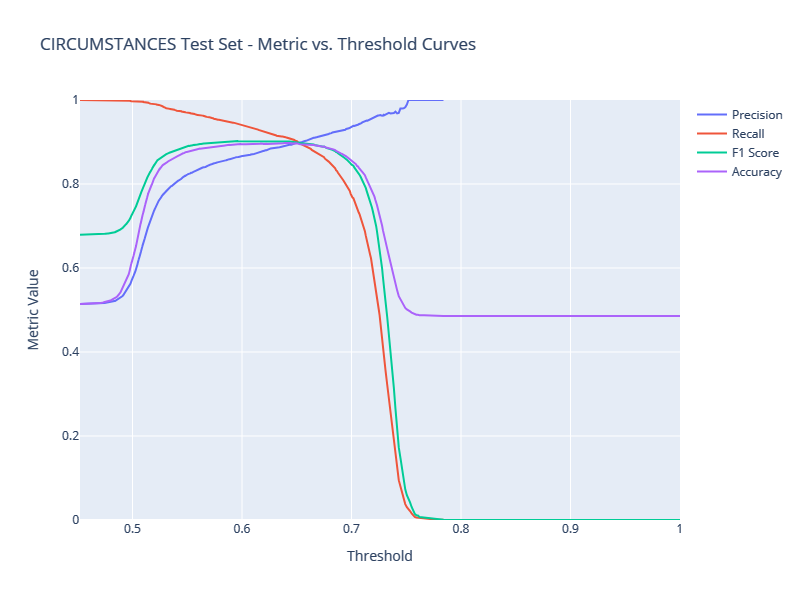

In [ ]:
# Plotting
fig = go.Figure()
# metric-Threshold curve
fig.add_trace(go.Scatter(x=thresholds, y=tps_ls, mode='lines', name='TP'))
fig.add_trace(go.Scatter(x=thresholds, y=fps_ls, mode='lines', name='FP'))
fig.add_trace(go.Scatter(x=thresholds, y=fns_ls, mode='lines', name='FN'))
fig.add_trace(go.Scatter(x=thresholds, y=tns_ls, mode='lines', name='TN'))
fig.update_layout(title='CIRCUMSTANCES Test Set - Confusion Matrix',xaxis_title='Threshold',yaxis_title='Metric Value',yaxis=dict(range=[0, 6000]),width=800, height=600)
fig.show()

In [ ]:
import plotly.graph_objects as go

# Assuming thresholds, tps_ls, fps_ls, fns_ls, and tns_ls are defined somewhere in your code

# Plotting
fig = go.Figure()

# Adding traces
fig.add_trace(go.Scatter(x=thresholds, y=tps_ls, mode='lines', name='TP'))
fig.add_trace(go.Scatter(x=thresholds, y=fps_ls, mode='lines', name='FP'))
fig.add_trace(go.Scatter(x=thresholds, y=fns_ls, mode='lines', name='FN'))
fig.add_trace(go.Scatter(x=thresholds, y=tns_ls, mode='lines', name='TN'))

# Updating layout with unified hover mode
fig.update_layout(
    title='CIRCUMSTANCES Test Set - Confusion Matrix',
    xaxis_title='Threshold',
    yaxis_title='Metric Value',
    yaxis=dict(range=[0, 6000]),
    width=800,
    height=600,
    hovermode='x unified'  # This is the key update for unified hover labels
)

fig.show()


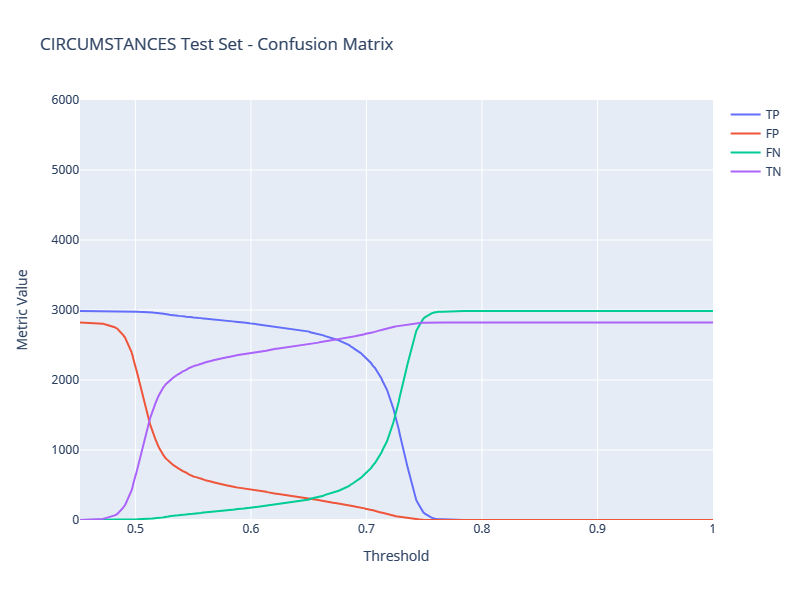

,Accuracy,Roc_Auc,F1_score,Precision,Recall,Support,TP,FP,TN,FN
0,0.894574,0.954034,0.896935,0.901795,0.892127,2985,2663,290,2530,322


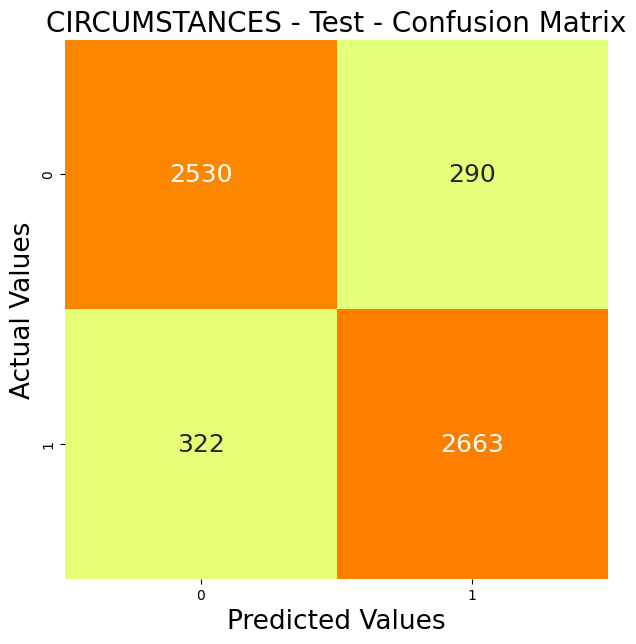

In [ ]:
final_threshold = 0.656

# Apply threshold to convert probabilities to binary predictions
predictions_test_large = (probabilities_test_large > final_threshold).astype(int)
cm_test_large = confusion_matrix(label_ids_test_large, predictions_test_large)
met_dic_test = {'Accuracy': accuracy_score(label_ids_test_large, predictions_test_large),'Roc_Auc': roc_auc_score(label_ids_test_large, probabilities_test_large),'F1_score': f1_score(label_ids_test_large, predictions_test_large),
        'Precision': precision_score(label_ids_test_large, predictions_test_large,),'Recall': recall_score(label_ids_test_large, predictions_test_large),'Support': cm_test_large[1][0]+cm_test_large[1][1],
        'TP' : cm_test_large[1][1],'FP' : cm_test_large[0][1],'TN' : cm_test_large[0][0],'FN' : cm_test_large[1][0]}
metrics_df_test_large = pd.DataFrame([met_dic_test])
display(metrics_df_test_large)


# Set up the plot
fig, ax = plt.subplots(figsize=(7, 7))
sns.heatmap(cm_test_large, annot=True,  annot_kws={"size": 18} ,fmt="d", cmap="Wistia", ax=ax,cbar=False)
# Set labels and title
ax.set_xlabel("Predicted Values", fontsize=19)
ax.set_ylabel("Actual Values", fontsize=19)
ax.set_title("CIRCUMSTANCES - Test - Confusion Matrix", fontsize=20)
import io
message_text = f"CIRCUMSTANCES - Test - final_threshold: {final_threshold}" +f"CIRCUMSTANCES Test metrics: {str(met_dic_test)}"
bot.send_message(chat_id,message_text);
# Save the plot to an in-memory file
buf = io.BytesIO()
plt.savefig(buf, format='png')
buf.seek(0)  # Go to the start of the IO stream
bot.send_photo(chat_id, buf)  # Replace 'chat_id' with the actual chat ID
plt.show()

In [ ]:
# test_large_df['prob'] = probabilities_test_large
# # test_large_df['pred'] = predictions_test_large
# pd.set_option('display.max_columns', 20000)

# test_large_df.sort_values(by='prob', ascending=False).head(20)
# test_large_df.to_csv('/content/drive/MyDrive/CIRC_test.csv', index=False)

In [ ]:
display(df.head(1))
display(eval_df.head(1))
display(test_large_df.head(1))

concat_df = pd.concat([df, eval_df, test_large_df])
display(concat_df.head())
display(concat_df.info())
concat_df.to_csv('/content/drive/MyDrive/CIRC_concat.csv', index=False)

,negotiationId,text,label,TFIDFKmeans_cluster,TFIDFDBSCAN_cluster,doc_length,stratify_col,stratify_col_circ,prob
0,5c2bee217e2c7a0001be8f89,I seen the officer pull over on the side of th...,1.0,14,-1,207,1.0_14,1.0_14,0.648689


,negotiationId,text,label,TFIDFKmeans_cluster,TFIDFDBSCAN_cluster,doc_length,stratify_col,stratify_col_circ,prob
0,5f89c48c9f3c7d0001d72382,I am years old and this is the first speeding ...,1.0,37,-1,358,1.0_37,1.0_37,0.73029


,negotiationId,text,label,TFIDFKmeans_cluster,TFIDFDBSCAN_cluster,doc_length,stratify_col,stratify_col_circ,prob
0,5fb02b9f7b67f30001874768,I want to apologize for my reckless driving on...,1.0,11,-1,1230,1.0_11,1.0_11,0.679179


,negotiationId,text,label,TFIDFKmeans_cluster,TFIDFDBSCAN_cluster,doc_length,stratify_col,stratify_col_circ,prob
0,5c2bee217e2c7a0001be8f89,I seen the officer pull over on the side of th...,1.0,14,-1,207,1.0_14,1.0_14,0.648689
1,5f85a373c560d40001ae3632,It was my first time driving on this street af...,1.0,59,-1,379,1.0_59,1.0_59,0.729520
2,5c76a232b3d7c80001cb9255,I am unable to come into court have and It is ...,0.0,48,-1,280,0.0_48,0.0_48,0.509947
3,5cc13fd17dfc8d000121e3b4,May I request a trial date to speak with the j...,1.0,29,-1,211,1.0_29,1.0_29,0.580352
4,61829df237de52000129acae,I would like to admit responsibility with expl...,1.0,56,-1,700,1.0_56,1.0_56,0.749087


<class 'pandas.core.frame.DataFrame'>
Int64Index: 29010 entries, 0 to 5804
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   negotiationId        29010 non-null  object 
 1   text                 29010 non-null  object 
 2   label                29010 non-null  float64
 3   TFIDFKmeans_cluster  29010 non-null  int64  
 4   TFIDFDBSCAN_cluster  29010 non-null  int64  
 5   doc_length           29010 non-null  int64  
 6   stratify_col         29010 non-null  object 
 7   stratify_col_circ    29010 non-null  object 
 8   prob                 29010 non-null  float32
dtypes: float32(1), float64(1), int64(3), object(4)
memory usage: 2.1+ MB


None

In [ ]:
# @title
# # Step 1: Calculate indices for TP and FP
# fp_indices = [i for i, (pred, label) in enumerate(zip(predictions_test_large, label_ids_test_large)) if pred == 1 and label == 0]
# fn_indices = [i for i, (pred, label) in enumerate(zip(predictions_test_large, label_ids_test_large)) if pred == 0 and label == 1]

# # Step 2: Filter the dataset to show texts for TP and FP
# fp_texts = test_large_df.loc[fp_indices, 'text']
# fn_texts = test_large_df.loc[fn_indices, 'text']

# # Step 3: Print texts for TP and FP
# print("\nFalse Positive Texts with IDs:")
# for i in fp_indices:  # Using indices to access rows
#     print(f"ID: {test_large_df.loc[i, 'negotiationId']}, Text: {test_large_df.loc[i, 'text']}")
#     print("---")  # Separator for readability

# print("False Negative Texts with IDs:")
# for i in fn_indices:  # Using indices to access rows
#     print(f"ID: {test_large_df.loc[i, 'negotiationId']}, Text: {test_large_df.loc[i, 'text']}")
#     print("---" )  # Separator for readability

# # '5c925eaf46bdc60001b98dfd,'5c89362e046196000170cbc7' a good example of not bad record wut similar
# # new_br_test = ['6082e442439c34000148f971']

# Requirements


0. Build all the processing units required to solve the problem, including training and testing pipelines
1. Build a binary classifier that predicts the dependent is_dupilcate variable for a given pair of questions.
2. Choose metrics for quality assessment and present the final results on both train- and test-data (at least..)
3. Discuss the results you have obtained.

The submitted solution must consist of a single executable Jupyter or Google Colab Notebook file / link that includes all the processing units required to solve the problem, including training and testing pipelines.

Additionally, it is necessary to **provide an explanation** of the *solution's essence* and the *final results obtained* within the Notebook itself, where in case of a colab link, keep the output cells visible.

## Loading a saved pretrained model

In [ ]:
# @title
# from peft import AutoPeftModelForSequenceClassification

# model = AutoPeftModelForSequenceClassification.from_pretrained(
#     "/content/final-checkpoint",
#     device_map="auto",
#     num_labels=1,
#     quantization_config=q_config,
# )
# score_weights = torch.load("path/to/checkpoint/score.original_module.pt", map_location='cpu')
# model.score.original_module.load_state_dict(score_weights)

## .

In [ ]:
# @title
# pred_dict_test = trainer.predict(tokenized_test_dataset)
# final_threshold = 0.51
# # Example logits from your predictions
# test_logits =  pred_dict_test[0] # Use your actual logits here
# # Convert logits to probabilities using the sigmoid function
# probabilities_test = 1 / (1 + np.exp(-test_logits))
# # Flatten arrays for compatibility with precision_score function
# probabilities_test = probabilities_test.flatten()
# label_ids_test = np.array(pred_dict_test[1])  # Use your actual label_ids here
# label_ids_test = label_ids_test.flatten()
# # Apply threshold to convert probabilities to binary predictions
# predictions_test = (probabilities_test > final_threshold).astype(int)
# cm_test = confusion_matrix(label_ids_test, predictions_test)
# metrics_df_test = pd.DataFrame({'Accuracy': [accuracy_score(label_ids_test, predictions_test)],'F1_score': [f1_score(label_ids_test, predictions_test,average='weighted')],
#         'Precision': [precision_score(label_ids_test, predictions_test,average='weighted')],'Recall': [recall_score(label_ids_test, predictions_test,average='weighted')],
#         'TP' : [cm_test[1][1]],'FP' : [cm_test[0][1]],'TN' : [cm_test[0][0]],'FN' : [cm_test[1][0]],},)
# display(metrics_df_test)
# # Set up the plot
# fig, ax = plt.subplots(figsize=(8, 8))
# sns.heatmap(cm_test, annot=True, fmt="d", cmap="Wistia", ax=ax)
# # Set labels and title
# ax.set_xlabel("Predicted Values", fontsize=12)
# ax.set_ylabel("Actual Values", fontsize=12)
# ax.set_title("test Confusion Matrix ", fontsize=14)
# # # Save the plot to an in-memory file
# # buf = io.BytesIO()
# # plt.savefig(buf, format='png')
# # buf.seek(0)  # Go to the start of the IO stream
# # # Send the plot
# # bot.send_photo(chat_id, buf)  # Replace 'chat_id' with the actual chat ID
# plt.show()

In [ ]:
# @title
# # @title
# # Create the data
# x = probabilities_test
# hist_data = [x]
# # Create the figure
# fig = ff.create_distplot(hist_data, ['probabilities_test'], show_hist=False, show_rug=False)
# # Update the layout
# fig.update_layout(title='KDE Plot for Test Set Probabilities',xaxis_title='Probability',yaxis_title='Density',width=800,height=600,)
# # Show the plot
# fig.show()